In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
os.chdir('gdrive/My Drive/electricity_usage_forecast/')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

Using TensorFlow backend.


#  Data load

In [4]:
target_original = pd.read_csv('data/first_data/target_v1.csv')
weather_original = pd.read_csv('data/first_data/weather_v1.csv')
hourly_smp_original = pd.read_csv('data/first_data/hourly_smp_v1.csv')

target = target_original.copy()
weather = weather_original.copy()
hourly_smp = hourly_smp_original.copy()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
oil_price_cl_original = pd.read_csv('data/oil/oil_price_cl.csv')
oil_price_du_original = pd.read_csv('data/oil/oil_price_du.csv')
oil_price_brt_original = pd.read_csv('data/oil/oil_price_brt.csv')

oil_price_cl = oil_price_cl_original.copy()
oil_price_du = oil_price_du_original.copy()
oil_price_brt = oil_price_brt_original.copy()

#  Preprocessing

### smp and oil data

In [0]:
def date_time_split(data) :
    data['date'] = pd.to_datetime(data['date'])

    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['weekday'] = data['date'].dt.weekday
    data['hour'] = data['date'].dt.hour

    data = data.drop(['date'], axis = 1)

    return data

In [0]:
target = date_time_split(target)
target = target.iloc[:, :-1]

In [0]:
def time_data(data, start, end) :
    
    # time data를 만들기 위해 각 데이터별 날짜의 최대 최솟값을 저장해둠
    period = pd.date_range(start = start, end = end)
    
     #time data 생성
    time_data = pd.DataFrame({'date' : period})
    time_data = date_time_split(time_data)
    
    return time_data

In [0]:
def make_oil_data(oil,start, end) :
    #oil_price에서 필요한 column(date, price)만을 추출함 
    oil = oil.iloc[:, 1:3]
    
    # target data의 날짜에 맞춰 sampling
    # oil의 가격은 3개월 이후의 smp에 영향을 미치므로 2017-11-02 이후의 데이터만을 sampling
    oil = oil[(oil['date'] >= start) & (oil['date'] <= end)]
    
    #날짜 순서대로 data를 sorting
    oil.sort_values(by = ['date'], inplace = True)
    
    #index를 0부터 시작되도록 초기화(후에 data를 merge할때 index가 다르면 error 발생)
    oil.reset_index(drop = True, inplace = True)

    oil = date_time_split(oil)

    return oil

In [0]:
def merge_oil(oil_1, oil_2, oil_3, time) :
    
    #time_data를 기준으로 oil data들을 merge함
    # 이때 주말의 oil data들은 존재하지 않으므로 모두 null값으로 들어감
    oil = pd.merge(left = time, right = oil_1, how = 'outer')
    oil = pd.merge(left = oil, right = oil_2, how = 'outer')
    oil = pd.merge(left = oil, right = oil_3, how = 'outer')
    
    #주말 oil data의 null값을 각 column의 평균으로 채움
    fillna = {'du_price' : oil.du_price.mean(), 'cl_price' : oil.cl_price.mean(), 'brt_price' : oil.brt_price.mean()}
    oil = oil.fillna(value = fillna)
    
    #oil 데이터의 날짜정보를 필요없으므로 drop
    oil = oil.iloc[ : , -3: ]
    
    return oil

In [0]:
oil_price_cl.columns = ['place', 'date', 'cl_price']
oil_price_du.columns = ['place', 'date', 'du_price']
oil_price_brt.columns = ['place', 'date', 'brt_price']

start = '2017-11-02'
end = '2019-11-01'

In [0]:
oil_cl = make_oil_data(oil_price_cl, start, end)
oil_du = make_oil_data(oil_price_du, start, end)
oil_brt = make_oil_data(oil_price_brt, start, end)

time = time_data(oil_cl, start, end)

In [0]:
oil = merge_oil(oil_cl, oil_du, oil_brt, time)

In [14]:
target = pd.concat([target, oil], axis = 1)
target

,smp_max,smp_min,smp_mean,supply,year,month,day,weekday,cl_price,du_price,brt_price
0,150.65,116.84,132.71,87.47,2018,2,1,3,54.540000,58.870000,60.620000
1,163.86,116.84,134.19,86.64,2018,2,2,4,55.640000,60.150000,62.070000
2,164.07,116.85,131.39,88.28,2018,2,3,5,60.888469,66.191494,67.863066
3,171.00,115.76,131.89,86.14,2018,2,4,6,60.888469,66.191494,67.863066
4,170.34,123.89,137.96,90.63,2018,2,5,0,57.350000,61.830000,64.270000
...,...,...,...,...,...,...,...,...,...,...,...
725,154.46,78.95,94.07,76.64,2020,1,27,0,55.810000,59.450000,61.570000
726,156.57,84.80,103.05,80.25,2020,1,28,1,55.540000,59.410000,61.590000
727,154.78,86.99,109.21,82.90,2020,1,29,2,55.060000,59.320000,60.610000
728,203.15,84.87,112.85,84.85,2020,1,30,3,54.180000,58.450000,60.230000


### temperature data

In [0]:
def temp_preprocessing(data) :
    
    #weather data에서 temp와 date를 제외한 모든 column drop
    data = data[data['area'] == 884]
    data = data.iloc[:, 1:3]
    data.reset_index(drop = True, inplace = True)
    data.columns = ['date', 'temp']
    
    #weather data의 date를 year, month, day, weekday, hour로 분해해줌
    data = date_time_split(data)
    
    #2018년 2월 1일 00시 데이터와 2019년 2월 1일 00시 데이터 누락
    #해당 데이터를 채워줌
    column = data.columns
    
    first_data = [round(data[data['month'] ==2]['temp'].mean(), 1) , 2018, 2, 1, 3, 0]
    second_data = [round(data[data['month'] ==2]['temp'].mean(), 1), 2019, 2, 1, 4, 0]
    time_data = [first_data, second_data]
    time_data = pd.DataFrame(time_data, columns = column)
    data = pd.concat([data, time_data])
    
    data.sort_values(by = ['year', 'month', 'day', 'weekday', 'hour'], inplace = True)
    data.reset_index(drop = True, inplace = True)
    
    return data

In [0]:
def make_daily_temp(data, window_size, daily_size) :
    
    #하루치 데이터마다 sampling하여 dict 자료구조로 저장
    weather_dict = {}
    for window in range(daily_size) :
        weather_dict[window] = data.iloc[window_size*window+1 : window_size*(window+1), : ]
        
    
    #동일한 기간의 날짜정보만 담은 dataframe 만들기
    start = '2018-02-01'
    end = '2020-01-31'

    period = pd.date_range(start = start, end = end)
    period = pd.DataFrame({'date' : period})
    period = date_time_split(period)
    period = period.iloc[ : , :-1]
    
    #시간별 온도들을 모아 하루치 평균 온도를 계산
    mean_temp = [0] * daily_size
    for window in range(daily_size) :
        mean_temp[window] = round(weather_dict[window]['temp'].mean(),1)
    
    period['temp'] = mean_temp
    
    return period

In [17]:
daily_size = 730
window_size = 24

weather = temp_preprocessing(weather)
weather = make_daily_temp(data = weather, window_size = window_size, daily_size = daily_size)
weather.head()

,year,month,day,weekday,temp
0,2018,2,1,3,4.2
1,2018,2,2,4,4.6
2,2018,2,3,5,0.7
3,2018,2,4,6,-1.7
4,2018,2,5,0,-0.5


### Combine both and make train

In [0]:
train = pd.merge(left = weather, right = target, on = ['year', 'month', 'day', 'weekday'])

time = train['year'].astype(str) + '-' + train['month'].astype(str) + '-' + train['day'].astype(str)
train['date'] = pd.to_datetime(time)

train = train[['date', 'year', 'month', 'day', 'weekday', 'temp', 'cl_price', 'du_price', 'brt_price', 'smp_min', 'smp_max', 'smp_mean', 'supply']]

In [19]:
train

,date,year,month,day,weekday,temp,cl_price,du_price,brt_price,smp_min,smp_max,smp_mean,supply
0,2018-02-01,2018,2,1,3,4.2,54.540000,58.870000,60.620000,116.84,150.65,132.71,87.47
1,2018-02-02,2018,2,2,4,4.6,55.640000,60.150000,62.070000,116.84,163.86,134.19,86.64
2,2018-02-03,2018,2,3,5,0.7,60.888469,66.191494,67.863066,116.85,164.07,131.39,88.28
3,2018-02-04,2018,2,4,6,-1.7,60.888469,66.191494,67.863066,115.76,171.00,131.89,86.14
4,2018-02-05,2018,2,5,0,-0.5,57.350000,61.830000,64.270000,123.89,170.34,137.96,90.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2020-01-27,2020,1,27,0,9.9,55.810000,59.450000,61.570000,78.95,154.46,94.07,76.64
726,2020-01-28,2020,1,28,1,9.1,55.540000,59.410000,61.590000,84.80,156.57,103.05,80.25
727,2020-01-29,2020,1,29,2,8.9,55.060000,59.320000,60.610000,86.99,154.78,109.21,82.90
728,2020-01-30,2020,1,30,3,7.2,54.180000,58.450000,60.230000,84.87,203.15,112.85,84.85


# Create windows 

In [0]:
smp_mean = train['smp_mean'].values

In [0]:
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(smp_mean) - sequence_length):
    result.append(smp_mean[index: index + sequence_length])

# Normalize data

In [0]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)
    
result = np.array(normalized_data)

# Split data

In [23]:
# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, 1:9]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, 11]

x_test = result[row:, 1:9]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, 11]

x_train.shape, x_test.shape

((611, 8, 1), (68, 8, 1))

# Build model

In [24]:
model = Sequential()

model.add(LSTM(8, return_sequences=True, input_shape=(8, 1)))

model.add(LSTM(64, return_sequences=True))

model.add(LSTM(128, return_sequences=True))

#model.add(Dropout(0.5))

model.add(LSTM(64, return_sequences=True))

model.add(LSTM(32, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8, 8)              320       
_________________________________________________________________
lstm_2 (LSTM)                (None, 8, 64)             18688     
_________________________________________________________________
lstm_3 (LSTM)                (None, 8, 128)            98816     
_________________________________________________________________
lstm_4 (LSTM)                (None, 8, 64)             49408     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 179,681
Trainable params: 179,681
Non-trainable params: 0
________________________________________________

# Training

In [25]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=100)

Train on 611 samples, validate on 68 samples
Epoch 1/100
611/611 [==============================] - 12s 19ms/step - loss: 0.0061 - val_loss: 0.0199
Epoch 2/100
611/611 [==============================] - 9s 14ms/step - loss: 0.0052 - val_loss: 0.0151
Epoch 3/100
611/611 [==============================] - 8s 14ms/step - loss: 0.0048 - val_loss: 0.0098
Epoch 4/100
611/611 [==============================] - 8s 14ms/step - loss: 0.0045 - val_loss: 0.0120
Epoch 5/100
611/611 [==============================] - 8s 14ms/step - loss: 0.0041 - val_loss: 0.0090
Epoch 6/100
611/611 [==============================] - 9s 14ms/step - loss: 0.0040 - val_loss: 0.0096
Epoch 7/100
611/611 [==============================] - 9s 14ms/step - loss: 0.0038 - val_loss: 0.0096
Epoch 8/100
611/611 [==============================] - 9s 14ms/step - loss: 0.0039 - val_loss: 0.0106
Epoch 9/100
611/611 [==============================] - 9s 14ms/step - loss: 0.0039 - val_loss: 0.0087
Epoch 10/100
611/611 [==============

# Prediction

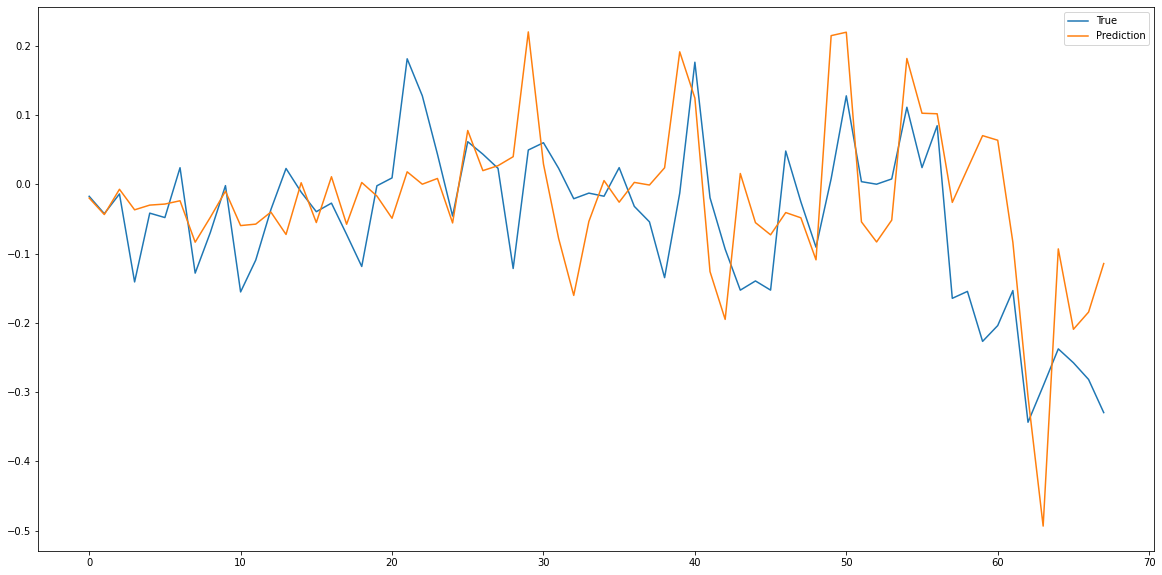

In [27]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()